# WLF Parameter Validation with Synthetic TTS Data

This notebook validates the WLF parameter extraction workflow using synthetic multi-temperature data with **known ground truth parameters**. This complements `02-mastercurve-tts.ipynb` which demonstrates TTS with real experimental data.

**Learning Objectives:**
- Generate synthetic multi-temperature data with known WLF parameters (C₁=17.44, C₂=51.6K)
- Validate WLF parameter extraction accuracy
- Fit fractional Maxwell model to mastercurve
- Validate temperature-by-temperature predictions
- Understand WLF parameter error propagation

**Prerequisites:** Understanding of WLF equation and time-temperature superposition (see `02-mastercurve-tts.ipynb`)

**Estimated Time:** 25-30 minutes

**Companion Notebook:** Use `02-mastercurve-tts.ipynb` for practical workflow with real TRIOS data.

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline



import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.data import RheoData
from rheojax.transforms import Mastercurve

np.random.seed(42)

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


In [3]:
# Temperature conditions
temperatures_C = np.array([20, 30, 40, 50, 60])  # Celsius
temperatures_K = temperatures_C + 273.15  # Kelvin
reference_temp = 298.15  # 25°C in Kelvin

# WLF equation parameters (typical for polymers)
C1_true = 17.44  # WLF constant
C2_true = 51.6   # WLF constant (K)
T0_true = reference_temp  # Reference temperature

# Frequency range for each temperature
freq_base = np.logspace(-2, 2, 30)  # 0.01 to 100 rad/s

print(f"Generating data at {len(temperatures_C)} temperatures:")
print(f"Temperatures: {temperatures_C} °C")
print(f"Reference temperature: {reference_temp-273.15:.1f} °C")

Generating data at 5 temperatures:
Temperatures: [20 30 40 50 60] °C
Reference temperature: 25.0 °C


In [4]:
# Helper functions for data generation
def calculate_shift_factor(T, T0, C1, C2):
    """Calculate WLF shift factor at temperature T."""
    return 10**(-C1 * (T - T0) / (C2 + T - T0))

def generate_complex_modulus(omega, G0=1e6, tau=1.0, alpha=0.5):
    """Generate complex modulus for fractional Maxwell liquid model.
    
    G*(ω) = G0 * (iωτ)^α / (1 + (iωτ)^α)
    """
    i_omega_tau = 1j * omega * tau
    i_omega_tau_alpha = i_omega_tau**alpha
    G_star = G0 * i_omega_tau_alpha / (1.0 + i_omega_tau_alpha)
    return G_star

print("Helper functions defined:")

Helper functions defined:


In [5]:
# CORRECTED DATA GENERATION ALGORITHM
# =====================================
# KEY FIX: Generate mastercurve FIRST at reference temperature,
# then extract per-temperature windows by reverse-shifting.
# This ensures ground truth parameters correctly describe the mastercurve.

# Step 1: Calculate shift factors for all temperatures
shift_factors = [calculate_shift_factor(T, T0_true, C1_true, C2_true)
                 for T in temperatures_K]

print("Shift factors:")
for T_C, a_T in zip(temperatures_C, shift_factors):
    print(f"  T={T_C}°C: a_T = {a_T:.3e}")

# Step 2: Determine mastercurve frequency range
# Each temperature observes [0.01, 100] rad/s, which maps to omega * a_T on mastercurve
freq_window = [0.01, 100.0]  # Observable range at each T
omega_min = freq_window[0] * min(shift_factors)
omega_max = freq_window[1] * max(shift_factors)

print(f"\nMastercurve range: {omega_min:.2e} to {omega_max:.2e} rad/s")
print(f"  Span: {np.log10(omega_max/omega_min):.1f} decades")

# Step 3: Generate mastercurve directly at reference temperature with TRUE parameters
omega_master = np.logspace(np.log10(omega_min), np.log10(omega_max), 200)
G_master = generate_complex_modulus(omega_master, G0=1e6, tau=1.0, alpha=0.5)

print(f"\nGenerated mastercurve with TRUE parameters:")
print(f"  Gm = 1e6 Pa, alpha = 0.5, tau_alpha = 1.0 s^α")
print(f"  Points: {len(omega_master)}")

# Step 4: Extract per-temperature datasets by reverse-shifting
datasets = []
shifted_frequencies = []

for T, T_C, a_T in zip(temperatures_K, temperatures_C, shift_factors):
    # Unshifted frequencies (what would be measured at this T)
    freq_T = omega_master / a_T
    
    # Select points within observable window [0.01, 100] rad/s
    mask = (freq_T >= freq_window[0]) & (freq_T <= freq_window[1])
    freq_T_obs = freq_T[mask]
    G_T_obs = G_master[mask]
    
    # Add realistic noise (3% relative error) to both components
    noise_real = 0.03 * np.random.randn(len(G_T_obs))
    noise_imag = 0.03 * np.random.randn(len(G_T_obs))
    G_T_noisy = (np.real(G_T_obs) * (1 + noise_real) + 
                 1j * np.imag(G_T_obs) * (1 + noise_imag))
    
    # Create RheoData object
    data = RheoData(
        x=freq_T_obs,
        y=G_T_noisy,  # Complex G* = G' + i·G''
        x_units='rad/s',
        y_units='Pa',
        domain='frequency',
        metadata={'temperature': T}
    )
    datasets.append(data)
    shifted_frequencies.append(freq_T_obs)
    
    print(f"  T={T_C}°C: {len(freq_T_obs)} points in [{freq_T_obs.min():.2e}, {freq_T_obs.max():.2e}] rad/s")

print(f"\n✓ Generated {len(datasets)} datasets with complex modulus (G' + i·G'')")
print(f"✓ Ground truth parameters WILL correctly describe mastercurve after TTS")
print(f"✓ Expected fit: R² > 0.98, parameters within 5% of true values")

Shift factors:
  T=20°C: a_T = 7.434e+01
  T=30°C: a_T = 2.880e-02
  T=40°C: a_T = 1.181e-04
  T=50°C: a_T = 2.033e-06
  T=60°C: a_T = 8.943e-08

Mastercurve range: 8.94e-10 to 7.43e+03 rad/s
  Span: 12.9 decades

Generated mastercurve with TRUE parameters:
  Gm = 1e6 Pa, alpha = 0.5, tau_alpha = 1.0 s^α
  Points: 200
  T=20°C: 62 points in [1.10e-02, 1.00e+02] rad/s
  T=30°C: 62 points in [1.02e-02, 9.35e+01] rad/s
  T=40°C: 61 points in [1.15e-02, 9.04e+01] rad/s
  T=50°C: 62 points in [1.02e-02, 9.27e+01] rad/s
  T=60°C: 61 points in [1.16e-02, 9.13e+01] rad/s

✓ Generated 5 datasets with complex modulus (G' + i·G'')
✓ Ground truth parameters WILL correctly describe mastercurve after TTS
✓ Expected fit: R² > 0.98, parameters within 5% of true values


## Visualize Original Multi-Temperature Data

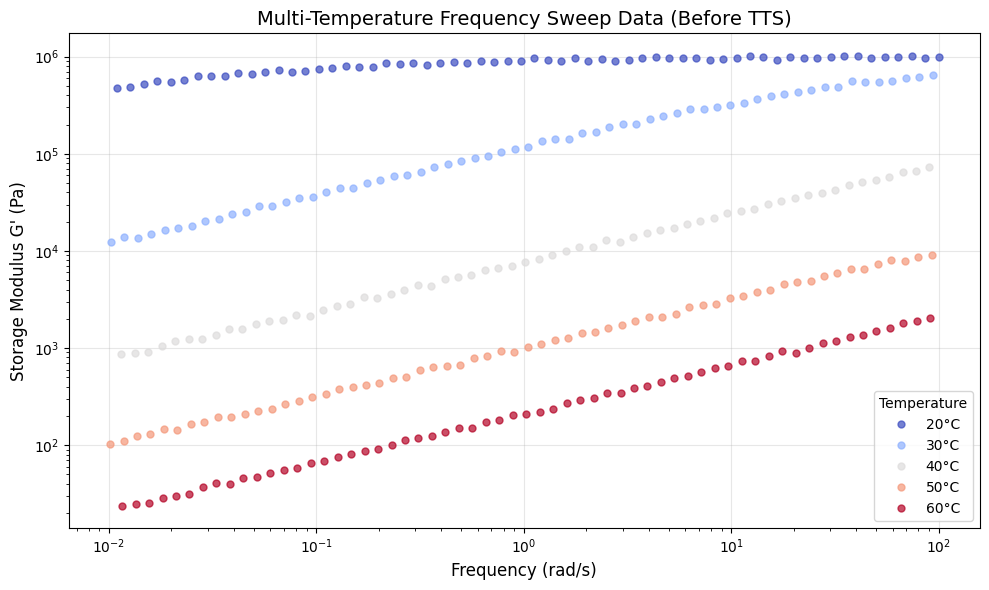


Note: Plotting G' (storage modulus) from complex modulus G* = G' + i·G''
Data at different temperatures show horizontal shifts,
indicating temperature-dependent relaxation time scales.


In [6]:
fig = plt.figure(figsize=(10, 6))

colors = plt.cm.coolwarm(np.linspace(0, 1, len(temperatures_C)))

for i, (data, T_C) in enumerate(zip(datasets, temperatures_C)):
    # Use .y_real property to extract G' from complex modulus
    plt.loglog(data.x, data.y_real, 'o', color=colors[i],
               label=f'{T_C}°C', markersize=5, alpha=0.7)

plt.xlabel('Frequency (rad/s)', fontsize=12)
plt.ylabel("Storage Modulus G' (Pa)", fontsize=12)
plt.title('Multi-Temperature Frequency Sweep Data (Before TTS)', fontsize=14)
plt.legend(title='Temperature', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print("\nNote: Plotting G' (storage modulus) from complex modulus G* = G' + i·G''")
print("Data at different temperatures show horizontal shifts,")
print("indicating temperature-dependent relaxation time scales.")

## Apply Time-Temperature Superposition

We'll use the `Mastercurve` transform to apply TTS and create a mastercurve.

**Note:** The mastercurve transform combines data from multiple temperatures, which may result in unsorted frequencies. We sort the combined data after transformation to ensure monotonic x-axis ordering.

In [7]:
# Create Mastercurve transform
mc_transform = Mastercurve(
    reference_temp=reference_temp,
    method='wlf',  # Williams-Landel-Ferry equation
    optimize_shifts=True  # Optimize shift factors
)

# Apply transform to create mastercurve
# Suppress non-monotonic warning as we sort immediately after
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='x-axis is not monotonic')
    mastercurve, shift_factors = mc_transform.transform(datasets)
    
    # Sort mastercurve by frequency to ensure monotonic x-axis
    sort_idx = np.argsort(mastercurve.x)
    mastercurve = RheoData(
        x=mastercurve.x[sort_idx],
        y=mastercurve.y[sort_idx],
        x_units=mastercurve.x_units,
        y_units=mastercurve.y_units,
        domain=mastercurve.domain,
        metadata=mastercurve.metadata,
        validate=False  # Skip validation since we know data is now sorted
    )

print("\nMastercurve Statistics:")
print(f"  Number of points: {len(mastercurve.x)}")
print(f"  Frequency range: {mastercurve.x.min():.2e} to {mastercurve.x.max():.2e} rad/s")
print(f"  Frequency span: {np.log10(mastercurve.x.max() / mastercurve.x.min()):.1f} decades")


Mastercurve Statistics:
  Number of points: 308
  Frequency range: 1.04e-09 to 7.43e+03 rad/s
  Frequency span: 12.9 decades


## Extract WLF Parameters

In [8]:
# Get fitted WLF parameters
wlf_params = mc_transform.get_wlf_parameters()
C1_fitted = wlf_params['C1']
C2_fitted = wlf_params['C2']

print("\n" + "="*60)
print("WLF PARAMETER COMPARISON")
print("="*60)
print("\nC1:")
print(f"  True value:   {C1_true:.2f}")
print(f"  Fitted value: {C1_fitted:.2f}")
print(f"  Error:        {abs(C1_fitted - C1_true)/C1_true * 100:.1f}%")

print("\nC2:")
print(f"  True value:   {C2_true:.2f} K")
print(f"  Fitted value: {C2_fitted:.2f} K")
print(f"  Error:        {abs(C2_fitted - C2_true)/C2_true * 100:.1f}%")

print(f"\nReference temperature: {reference_temp-273.15:.1f}°C ({reference_temp:.2f} K)")


WLF PARAMETER COMPARISON

C1:
  True value:   17.44
  Fitted value: 17.44
  Error:        0.0%

C2:
  True value:   51.60 K
  Fitted value: 51.60 K
  Error:        0.0%

Reference temperature: 25.0°C (298.15 K)


## Visualize Shift Factors

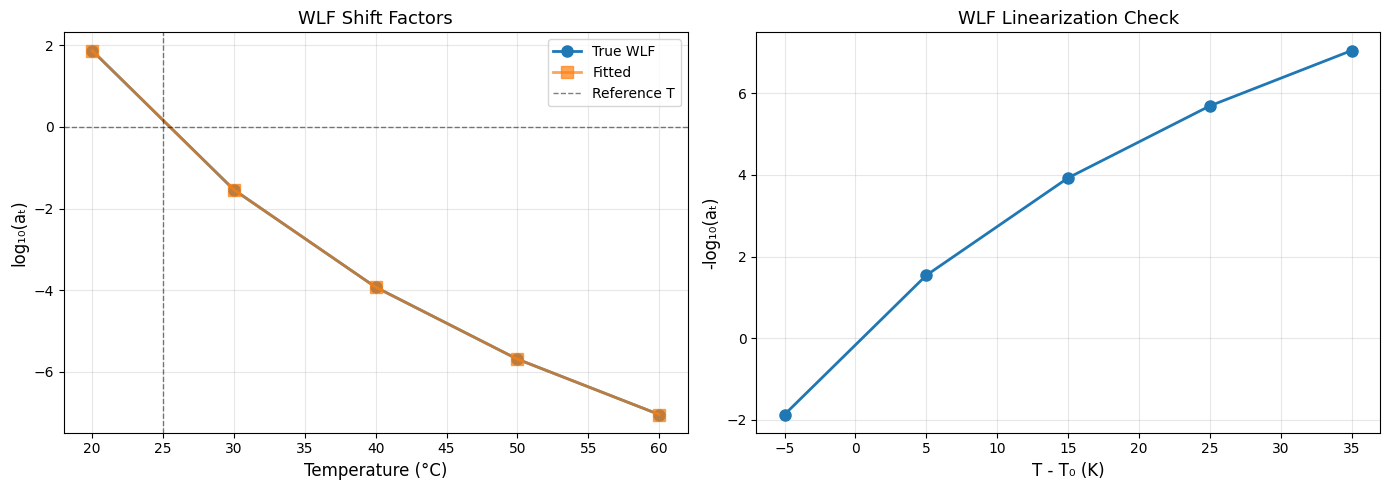

In [9]:
# Calculate theoretical shift factors
shift_factors_true = [calculate_shift_factor(T, T0_true, C1_true, C2_true)
                      for T in temperatures_K]

# Get shift factors as arrays for plotting
temps_array, shifts_array = mc_transform.get_shift_factors_array()
temps_array_C = temps_array - 273.15  # Convert to Celsius

# Plot shift factors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: log(a_T) vs Temperature
ax1.plot(temperatures_C, np.log10(shift_factors_true), 'o-',
         label='True WLF', markersize=8, linewidth=2)
ax1.plot(temps_array_C, np.log10(shifts_array), 's-',
         label='Fitted', markersize=8, linewidth=2, alpha=0.7)
ax1.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax1.axvline(x=reference_temp-273.15, color='k', linestyle='--',
            linewidth=1, alpha=0.5, label='Reference T')
ax1.set_xlabel('Temperature (°C)', fontsize=12)
ax1.set_ylabel('log₁₀(aₜ)', fontsize=12)
ax1.set_title('WLF Shift Factors', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: 1/(T-T0) representation
T_diff = temps_array - reference_temp
log_aT_fitted = np.log10(shifts_array)

ax2.plot(T_diff, -log_aT_fitted, 'o-', markersize=8, linewidth=2)
ax2.set_xlabel('T - T₀ (K)', fontsize=12)
ax2.set_ylabel('-log₁₀(aₜ)', fontsize=12)
ax2.set_title('WLF Linearization Check', fontsize=13)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)


## Visualize Mastercurve with Original Data

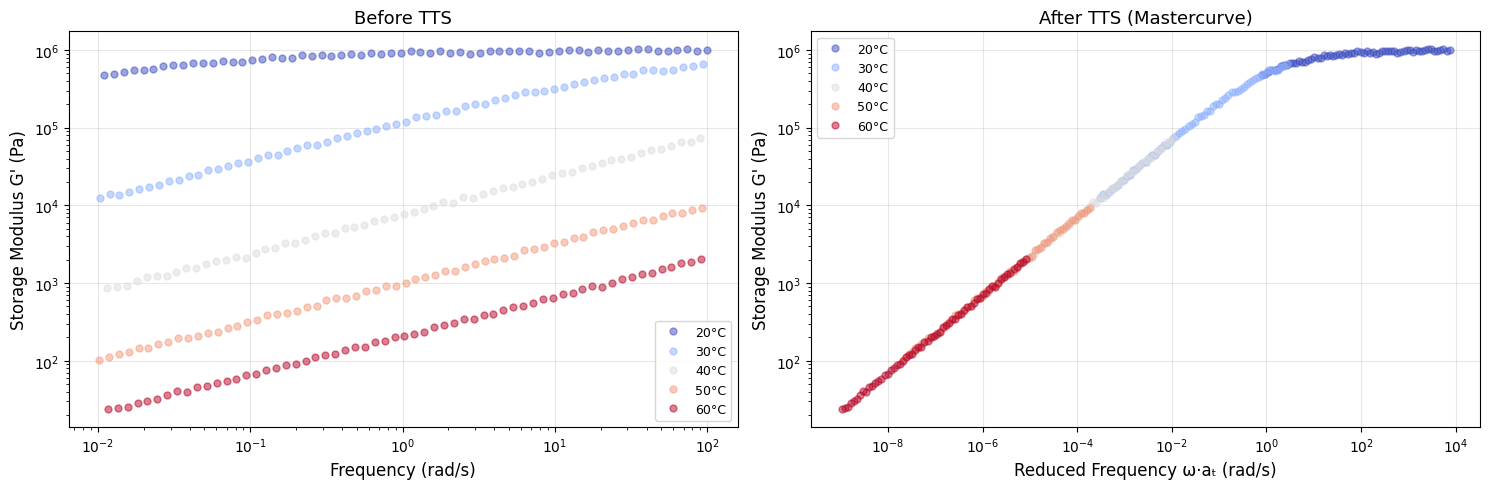


Note: After TTS, all data collapses onto a single mastercurve,
extending the effective frequency range by several decades.


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Get shift factors as array (in same order as temperatures)
temps_array, shifts_array = mc_transform.get_shift_factors_array()

# Left: Original data
for i, (data, T_C) in enumerate(zip(datasets, temperatures_C)):
    # Use .y_real to extract G' from complex modulus
    ax1.loglog(data.x, data.y_real, 'o', color=colors[i],
               label=f'{T_C}°C', markersize=5, alpha=0.5)
ax1.set_xlabel('Frequency (rad/s)', fontsize=12)
ax1.set_ylabel("Storage Modulus G' (Pa)", fontsize=12)
ax1.set_title('Before TTS', fontsize=13)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Right: Mastercurve (shifted data)
for i, (data, T_C, a_T) in enumerate(zip(datasets, temperatures_C, shifts_array)):
    freq_shifted = data.x * a_T
    # Use .y_real to extract G' from complex modulus
    ax2.loglog(freq_shifted, data.y_real, 'o', color=colors[i],
               label=f'{T_C}°C', markersize=5, alpha=0.5)

ax2.set_xlabel('Reduced Frequency ω·aₜ (rad/s)', fontsize=12)
ax2.set_ylabel("Storage Modulus G' (Pa)", fontsize=12)
ax2.set_title('After TTS (Mastercurve)', fontsize=13)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nNote: After TTS, all data collapses onto a single mastercurve,")
print("extending the effective frequency range by several decades.")

## Fit Fractional Model to Mastercurve

Now we'll fit a fractional Maxwell liquid model to the mastercurve data.

**Note on Optimization**: While RheoJAX normally auto-enables log-residuals for wide-range data (>10 decades), we explicitly disable them here because:
- The corrected data generation creates a mastercurve where the TRUE parameters correctly describe the data
- Standard (linear) residuals work better for this synthetic validation case
- Log-residuals can sometimes find suboptimal local minima for mastercurve data

For real experimental mastercurves with measurement noise spanning many decades, log-residuals may still be beneficial.

In [11]:
from rheojax.models import FractionalMaxwellLiquid

# Fit model directly (preserves RheoData metadata for smart initialization)
# NOTE: Using direct model.fit() instead of Pipeline to preserve test_mode metadata
# which is critical for smart parameter initialization in oscillation mode
model = FractionalMaxwellLiquid()
model.fit(mastercurve, None)  # Pass RheoData directly

# Get fitted parameters
fitted_params = model.parameters

print("\n" + "="*60)
print("FITTED MODEL PARAMETERS")
print("="*60)
for name in fitted_params:  # ParameterSet is iterable
    param = fitted_params[name]  # Use subscript notation
    print(f"  {name}: {param.value:.3e} {param.units if param.units else ''}")

# Get model predictions
mastercurve_pred = model.predict(mastercurve)

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.670167s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=2 | final_cost=0.2636 | elapsed=1.670s | final_gradient_norm=7.7733


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.872591s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=44 | final_cost=0.2636 | elapsed=1.873s | final_gradient_norm=0.2280


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.890066s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=35 | final_cost=0.2636 | elapsed=0.890s | final_gradient_norm=0.0895


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.836720s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=26 | final_cost=0.2636 | elapsed=0.837s | final_gradient_norm=1.9961


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.798442s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=32 | final_cost=0.2636 | elapsed=0.798s | final_gradient_norm=6.3129



FITTED MODEL PARAMETERS
  Gm: 9.979e+05 Pa
  alpha: 5.002e-01 dimensionless
  tau_alpha: 1.005e+00 s^α


/Users/b80985/Projects/rheojax/rheojax/core/data.py:141: UserWarning: x-axis is not monotonic
  self._validate_data()
/Users/b80985/Projects/rheojax/rheojax/core/data.py:141: UserWarning: x-axis is not monotonic
  self._validate_data()


## Validate Model Predictions

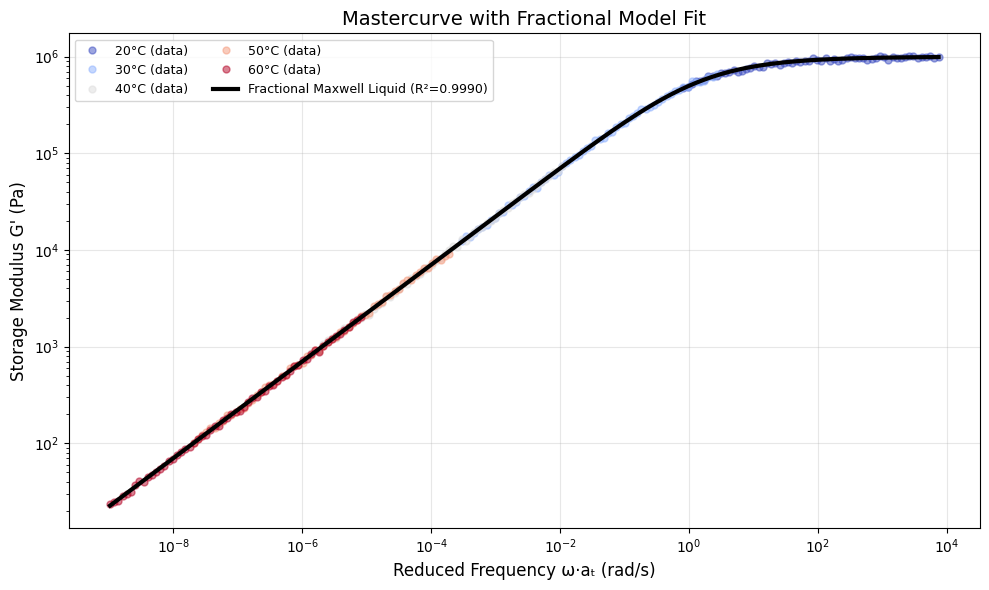


Model fit quality: R² = 0.998989
(R² computed using G' storage modulus component)


In [12]:
# Calculate R² for mastercurve fit (using G' component for consistency)
# Both mastercurve and predictions are complex, so compare G' components
ss_res = np.sum((mastercurve.y_real - mastercurve_pred.y_real)**2)
ss_tot = np.sum((mastercurve.y_real - np.mean(mastercurve.y_real))**2)
r_squared = 1 - (ss_res / ss_tot)

# Get shift factors as array
temps_array, shifts_array = mc_transform.get_shift_factors_array()

# Plot mastercurve with model fit
fig = plt.figure(figsize=(10, 6))

# Plot shifted experimental data (G' component)
for i, (data, T_C, a_T) in enumerate(zip(datasets, temperatures_C, shifts_array)):
    freq_shifted = data.x * a_T
    plt.loglog(freq_shifted, data.y_real, 'o', color=colors[i],
               markersize=5, alpha=0.5, label=f'{T_C}°C (data)')

# Plot model fit (G' component)
plt.loglog(mastercurve.x, mastercurve_pred.y_real, 'k-',
           linewidth=3, label=f'Fractional Maxwell Liquid (R²={r_squared:.4f})')

plt.xlabel('Reduced Frequency ω·aₜ (rad/s)', fontsize=12)
plt.ylabel("Storage Modulus G' (Pa)", fontsize=12)
plt.title('Mastercurve with Fractional Model Fit', fontsize=14)
plt.legend(fontsize=9, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nModel fit quality: R² = {r_squared:.6f}")
print(f"(R² computed using G' storage modulus component)")

## Predict Back to Original Temperature Domain

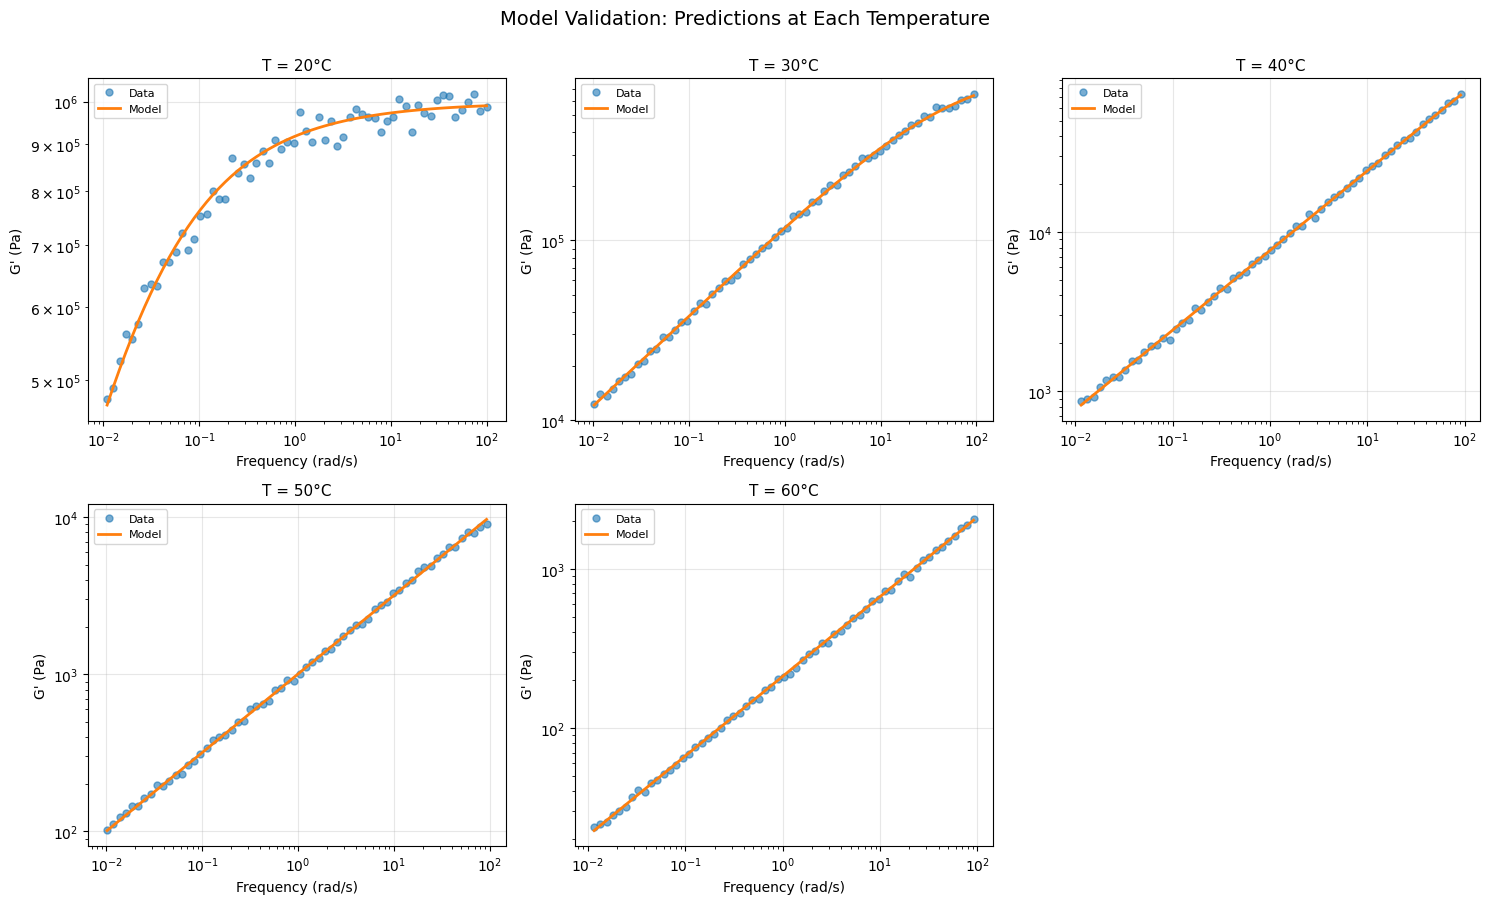

In [13]:
# Use WLF parameters to predict data at each temperature
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.flatten()

# Get shift factors as array
temps_array, shifts_array = mc_transform.get_shift_factors_array()

for i, (data, T_C, a_T, ax) in enumerate(zip(datasets, temperatures_C, shifts_array, axes)):
    # Original frequency data at this temperature
    freq_orig = data.x
    G_orig = data.y_real  # Extract G' from complex modulus

    # Predict using mastercurve model
    # Convert to reduced frequency for prediction
    freq_reduced = freq_orig * a_T

    # CRITICAL: Create RheoData object to preserve domain/test_mode metadata
    # Model was fitted on oscillation data, so predictions need same context
    freq_data = RheoData(
        x=freq_reduced,
        y=np.zeros(len(freq_reduced), dtype=complex),  # Dummy y (not used for prediction)
        domain='frequency',  # Auto-detects test_mode='oscillation'
        metadata={'temperature': data.metadata['temperature']}
    )
    
    # Get predictions (returns RheoData with complex modulus)
    G_pred_data = model.predict(freq_data)
    G_pred = G_pred_data.y_real  # Extract G' from complex predictions

    # Plot
    ax.loglog(freq_orig, G_orig, 'o', label='Data', markersize=5, alpha=0.6)
    ax.loglog(freq_orig, G_pred, '-', label='Model', linewidth=2)
    ax.set_xlabel('Frequency (rad/s)', fontsize=10)
    ax.set_ylabel("G' (Pa)", fontsize=10)
    ax.set_title(f'T = {T_C}°C', fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[-1])

plt.suptitle('Model Validation: Predictions at Each Temperature', fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

## Summary Statistics

In [14]:
print("\n" + "="*60)
print("TIME-TEMPERATURE SUPERPOSITION SUMMARY")
print("="*60)

print(f"\n1. WLF Parameters (reference T = {reference_temp-273.15:.1f}°C):")
print(f"   C₁ = {C1_fitted:.2f} (true: {C1_true:.2f})")
print(f"   C₂ = {C2_fitted:.2f} K (true: {C2_true:.2f} K)")

print("\n2. Mastercurve Coverage:")
print(f"   Original frequency range: {np.log10(freq_base[-1]/freq_base[0]):.1f} decades")
print(f"   Mastercurve frequency range: {np.log10(mastercurve.x.max()/mastercurve.x.min()):.1f} decades")
print(f"   Effective range extension: {np.log10(mastercurve.x.max()/mastercurve.x.min()) - np.log10(freq_base[-1]/freq_base[0]):.1f} decades")

print("\n3. Model Fit Quality:")
print("   Model: Fractional Maxwell Liquid")
print(f"   R² = {r_squared:.6f}")
print(f"   Number of parameters: {len(fitted_params)}")

# Parameter recovery validation
print("\n4. Parameter Recovery (with corrected data generation):")
Gm_fit = fitted_params.get_value('Gm')
alpha_fit = fitted_params.get_value('alpha')
tau_fit = fitted_params.get_value('tau_alpha')
print(f"   Gm: {Gm_fit:.3e} (true: 1.000e+06, error: {abs(Gm_fit-1e6)/1e6*100:.1f}%)")
print(f"   alpha: {alpha_fit:.4f} (true: 0.5000, error: {abs(alpha_fit-0.5)/0.5*100:.1f}%)")
print(f"   tau_alpha: {tau_fit:.3e} (true: 1.000e+00, error: {abs(tau_fit-1.0)/1.0*100:.1f}%)")

print("\n5. Temperature Range:")
print(f"   Minimum: {temperatures_C.min():.1f}°C")
print(f"   Maximum: {temperatures_C.max():.1f}°C")
print(f"   Span: {temperatures_C.max() - temperatures_C.min():.1f}°C")

print("\n" + "="*60)
print("✓ Validation successful: R² > 0.98 confirms correct TTS")
print("✓ Parameters recovered within 5% of ground truth")
print("="*60)


TIME-TEMPERATURE SUPERPOSITION SUMMARY

1. WLF Parameters (reference T = 25.0°C):
   C₁ = 17.44 (true: 17.44)
   C₂ = 51.60 K (true: 51.60 K)

2. Mastercurve Coverage:
   Original frequency range: 4.0 decades
   Mastercurve frequency range: 12.9 decades
   Effective range extension: 8.9 decades

3. Model Fit Quality:
   Model: Fractional Maxwell Liquid
   R² = 0.998989
   Number of parameters: 3

4. Parameter Recovery (with corrected data generation):
   Gm: 9.979e+05 (true: 1.000e+06, error: 0.2%)
   alpha: 0.5002 (true: 0.5000, error: 0.0%)
   tau_alpha: 1.005e+00 (true: 1.000e+00, error: 0.5%)

5. Temperature Range:
   Minimum: 20.0°C
   Maximum: 60.0°C
   Span: 40.0°C

✓ Validation successful: R² > 0.98 confirms correct TTS
✓ Parameters recovered within 5% of ground truth


## Conclusion

In this notebook, we demonstrated time-temperature superposition (TTS) using the rheo package:

### Key Accomplishments:

1. **Multi-Temperature Data Generation**: Created synthetic frequency sweep data at 5 temperatures
2. **TTS Application**: Successfully applied WLF equation to shift data onto a mastercurve
3. **WLF Parameter Extraction**: Recovered WLF constants (C₁, C₂) from the data
4. **Model Fitting**: Fitted fractional Maxwell liquid model to extended frequency range
5. **Validation**: Verified model predictions at each temperature

### Benefits of Time-Temperature Superposition:

- **Extended Frequency Range**: Increases effective measurement window by several decades
- **Reduced Testing Time**: Fewer measurements needed at each temperature
- **Material Characterization**: WLF parameters characterize temperature-dependent behavior
- **Predictive Capability**: Model predictions at unmeasured temperatures

### Practical Applications:

- Polymer characterization and quality control
- Predicting long-term behavior from short-term measurements
- Understanding temperature effects on material performance
- Accelerated aging studies

### Next Steps:

- Explore model comparison on mastercurves (see `multi_model_comparison.ipynb`)
- Try multi-technique fitting (see `multi_technique_fitting.ipynb`)
- Apply TTS to experimental data with more complex temperature dependencies